# ------------------------------------------------------------------------------
#
# This Example shows how to create a full project from scratch in HFSS and Icepak (linked to HFSS). the project creates
# a setup, solves it and create post processing output. It includes a lot of commands to show pyaedt Capabilities
#
# -------------------------------------------------------------------------------

In [1]:
import os
import sys
import pathlib
import glob
from IPython.display import Image

local_path = os.path.abspath('')
module_path = pathlib.Path(local_path)
aedt_lib_path = module_path.parent.parent.parent
pdf_path1 =  os.path.join(aedt_lib_path, "pyaedt", "core", "Dlls", "PDFReport")
sys.path.append(os.path.join(module_path))
sys.path.append(os.path.join(aedt_lib_path))
sys.path.append(os.path.join(pdf_path1))
from pyaedt import generate_unique_name
project_dir = os.path.join(os.environ["TEMP"], generate_unique_name("Example"))
if not os.path.exists(project_dir): os.makedirs(project_dir)
print(project_dir)


C:\Users\mcapodif\AppData\Local\Temp\Example_1X813O


# Import all needed Libraries

**NOTE. Numpy and Matplotlib is needed for the last part of exercise**


In [2]:
from pyaedt import Hfss
from pyaedt import Icepak
from pyaedt import Desktop
import clr
clr.AddReference("AnsysReport")
from pyaedt.application.DataHandlers import create_table_for_csharp, create_list_for_csharp
import AnsysReport
import numpy as np
import matplotlib.pyplot as plt
import math
advanced = True


## Define Project Directory, AEDT Version and Project Name

Project will be run in Graphical Mode

In [3]:
desktopVersion = "2021.1"
NonGraphical = True
NewThread = False
project_name = "Test_Jupyter_NG"
project_file = os.path.join(project_dir, project_name + ".aedt")

## Launch Electronics Desktop and Initialize HFSS app

the command 

```Python
aedtapp = Hfss()
```


Initializes the HFSS Design in AEDT. if there is a running HFSS Design the aedtapp will be linked to it, otherwise a new design will be run.

In [4]:
desktop=Desktop(desktopVersion, NonGraphical, NewThread)
aedtapp = Hfss()

Info: Using Windows TaskManager to Load processes
Info: Ansoft.ElectronicsDesktop.2021.1 Started with Process ID 25532
Info: pyaedt v0.5.0 started
Info: Started external COM connection with module pythonnet_v3
Info: Python version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Info: Exe path: C:\Anaconda3\python.exe
Info: Added design 'HFSS_DZ4' of type HFSS
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


## Variables Settings

A variable can be initialized simpy by creating it as a list object. if user enter $ then the variable will be created for project otherwise for design.

In [5]:
aedtapp["$coax_dimension"] = "100mm"
aedtapp.save_project(project_file)
udp = aedtapp.modeler.Position(0, 0, 0)
aedtapp["inner"] = "3mm"

Info: Saving Project138 Project


## Modeler 
Create the Coaxial, 3 Cylinders.

Parameters can be applied directly to create_cylinder method, also material can be assigned directly to the object creation action.
Alternatively the material can be assigned usign assignmaterial function


In [6]:
id1 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, "inner", "$coax_dimension",
                                                 0, "inner")
id2 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, 8, "$coax_dimension",
                                                 0, matname="teflon_based")
id3 = aedtapp.modeler.primitives.create_cylinder(aedtapp.CoordinateSystemPlane.XYPlane, udp, 10, "$coax_dimension",
                                                 0, "outer")
aedtapp["$height"] = "150mm"
aedtapp.assignmaterial([id1, id3], "Copper")

Info: Assign Material copper to object inner,outer


True

## Modeler Operations

Subtract, add, etc. can be done using id of object or object name

In [7]:
aedtapp.modeler.subtract(id3, id2, True)
aedtapp.modeler.subtract(id2, id1, True)

True

## Mesh Operations



In [8]:
aedtapp.mesh.assign_initial_mesh_from_slider(6)
aedtapp.mesh.assign_model_resolution([aedtapp.modeler.primitives.get_obj_name(id1), aedtapp.modeler.primitives.get_obj_name(id3)], None)
aedtapp.mesh.assign_length_mesh(aedtapp.modeler.primitives.get_object_faces(id2), False, 1, 2000)

## Automatic Excitations Creation


In [9]:
aedtapp.create_wave_port_between_objects("inner", "outer",axisdir=0, add_pec_cap=True, portname="P1")
aedtapp.create_wave_port_between_objects("inner", "outer",axisdir=3, add_pec_cap=True, portname="P2")
portnames = aedtapp.get_all_sources()
aedtapp.modeler.fit_all()

Info: Deleted 1 Objects
Info: Deleted 1 Objects
Info: Connection Correctly created
Info: Assign Material pec to object inner_ObjectFromEdge1_1
Info: Deleted 1 Objects
Info: Deleted 1 Objects
Info: Connection Correctly created
Info: Assign Material pec to object inner_ObjectFromEdge2_1


## Setup Generation

In [10]:
aedtapp.set_active_design(aedtapp.design_name)
setup = aedtapp.create_setup("MySetup")
setup.props["Frequency"] = "1GHz"
setup.props["BasisOrder"] = 2
setup.props["MaximumPasses"] = 1
setup.update()
sweepname = aedtapp.create_frequency_sweep("MySetup", "GHz", 0.8, 1.2)

# ICEPAK Model Creation
## Import model from HFSS

In [11]:
ipkapp = Icepak()
ipkapp.copy_solid_bodies_from(aedtapp)

Info: Added design 'Icepak_Y5A' of type Icepak
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


True

## Import model from HFSS

In [12]:
surfaceobj = ["inner", "outer"]
ipkapp.assign_em_losses(aedtapp.design_name, "MySetup", "LastAdaptive", "1GHz", surfaceobj, paramlist=["$coax_dimension","inner"])
ipkapp.edit_design_settings(aedtapp.GravityDirection.ZNeg)

Info: Mapping HFSS EM Lossess
Info: Found 4 Objects
Info: EM losses Mapped from design HFSS_DZ4


True

## Setup Project in Icepak

When you create a setup, default settings will be applied
When you need to change a property of the setup you can use props command and pass the right value to the property value. The update function will apply the settings to the setup

In [13]:
setup_ipk = ipkapp.create_setup("SetupIPK")
setup_ipk.props["Convergence Criteria - Max Iterations"] = 3
setup_ipk.update()

True

## Mesh Settings

In [15]:
airbox = ipkapp.modeler.primitives.get_obj_id("Region")
ipkapp.modeler.primitives[airbox].display_wireframe(True)
airfaces = ipkapp.modeler.primitives.get_object_faces(airbox)
ipkapp.assign_openings(airfaces)

Info: Face List boundary_faces created
Info: Opening Assigned


## Cloase and Open Projects
This command shows how to save, close and load projects. This can be helpful in case of operations on multiple projects.


In [16]:
aedtapp.save_project()
aedtapp.close_project(project_name)
aedtapp.load_project(project_file)
ipkapp = Icepak()
ipkapp.solution_type = ipkapp.SolutionTypes.Icepak.SteadyTemperatureAndFlow
ipkapp.modeler.fit_all()

Info: Saving Test_Jupyter_NG Project
Info: Closing the specified Test_Jupyter_NG AEDT Project
Info: Design Loaded
Info: Successfully loaded project materials !
Info: Materials Loaded


## Solve Icepak
Icepak will solve also 
Solve HFSS Sweep when Icepak is finished

In [17]:
setup1 = ipkapp.analyze_setup("SetupIPK")
aedtapp.save_project()
aedtapp.modeler.fit_all()
aedtapp.analyze_setup("MySetup")

Info: Solving design setup SetupIPK
Info: Saving Test_Jupyter_NG Project
Info: Solving design setup MySetup


True

# Plot and Export
## Generating images and Field Plots
This section we generate Field Plots on HFSS Projects and we export it as an image
** NOTE, the generation and export of jpg works only if AEDT is launched in graphical mode **


In [18]:
cutlist = ["Global:XY", "Global:XZ", "Global:YZ"]
vollist = [aedtapp.modeler.primitives.get_obj_name(id2)]
setup_name = "MySetup : LastAdaptive"
quantity_name = "ComplexMag_E"
quantity_name2 = "ComplexMag_H"
surflist = aedtapp.modeler.primitives.get_object_faces(id1)
intrinsic = {"Freq": "1GHz", "Phase": "0deg"}
surflist = aedtapp.modeler.primitives.get_object_faces("outer")
plot1 = aedtapp.post.create_fieldplot_surface(surflist, quantity_name2, setup_name, intrinsic)


In [19]:
results_folder = os.path.join(aedtapp.project_path,"Coaxial_Results_NG")
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

C:\Users\mcapodif\AppData\Local\Temp\Example_1X813O\Coaxial_Results_NG\ComplexMag_H_EIJ7TL
Info: PyVista Generation tooks 0.7079648971557617 secs
Field Generation, export and plot time:  1.739983081817627


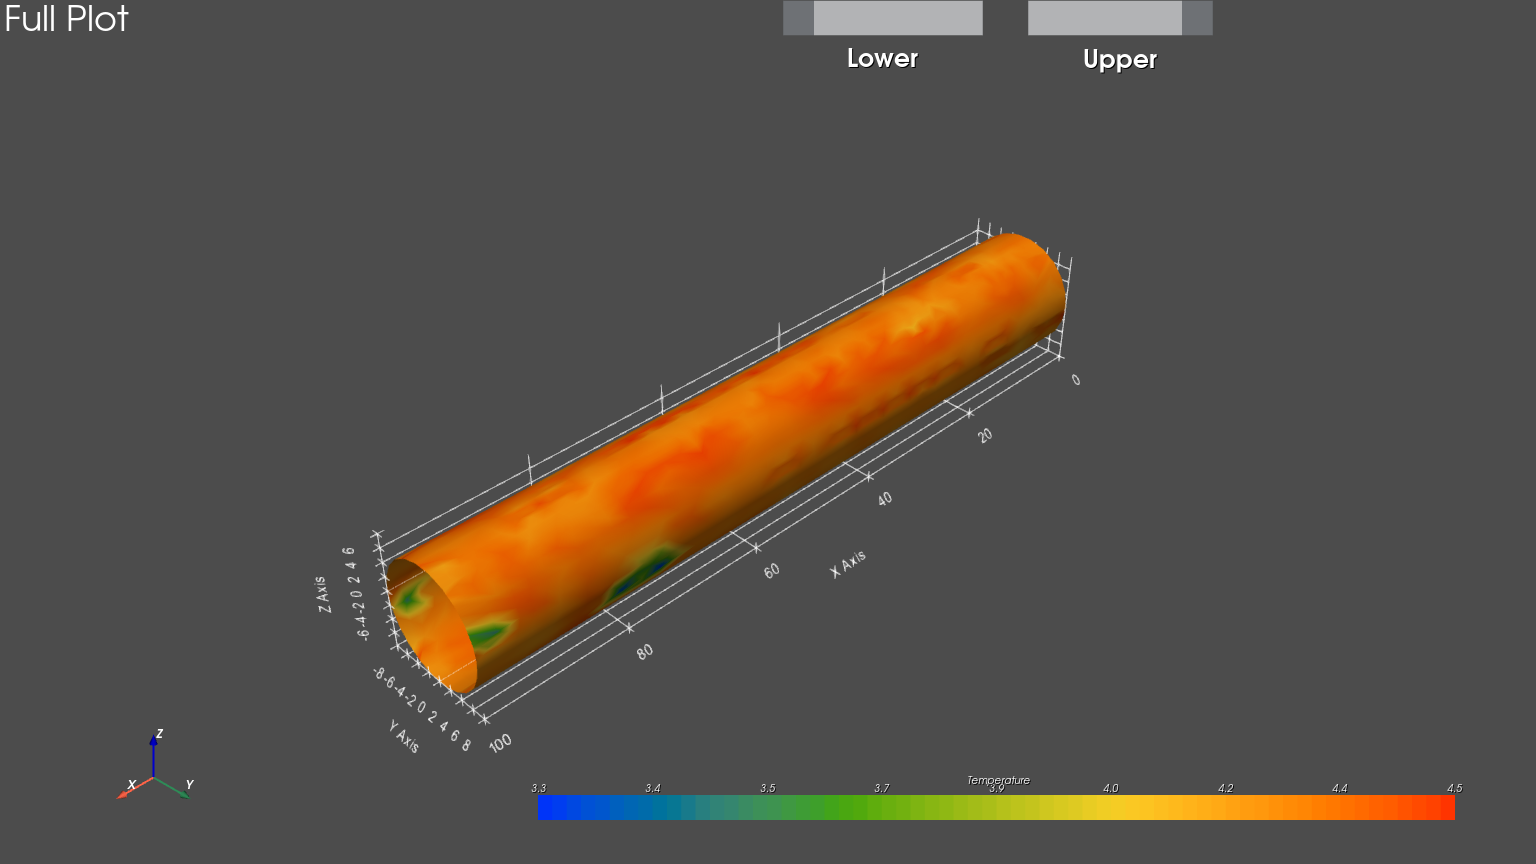

['C:\\Users\\mcapodif\\AppData\\Local\\Temp\\Example_1X813O\\Coaxial_Results_NG\\ComplexMag_H_EIJ7TL.jpg']

In [20]:
aedtapp.post.plot_field_from_fieldplot(plot1.name, project_path=results_folder, meshplot=False, setup_name=setup_name,
                                             intrinsic_dict=intrinsic, imageformat="jpg", view="iso")

Plotting Animation. It will open a separate UI with Animated plot. To Exit press Q

In [21]:

import time
start = time.time()
cutlist = ["Global:XY"]
phases=[str(i*5)+"deg" for i in range(18)]
aedtapp.post.animate_fields_from_aedtplt_2(quantityname="Mag_E",object_list=cutlist,plottype="CutPlane",meshplot=False, setup_name=aedtapp.nominal_adaptive,intrinsic_dict={"Freq":"1GHz", "Phase":"0deg"},project_path=results_folder, variation_variable="Phase",variation_list=phases)
endtime = time.time() - start
print("Total Time",endtime)

C:\Users\mcapodif\AppData\Local\Temp\Example_1X813O\Coaxial_Results_NG\Mag_E_YE2AUD0
Total Time 6.4915571212768555


# Create Icepak Plots and export
Functions are exactly the same as seen above for HFSS. Only the Quantity is different. 

In [22]:
quantity_name = "Temperature"
setup_name = ipkapp.existing_analysis_sweeps[0]
intrinsic = ""
surflist = ipkapp.modeler.primitives.get_object_faces("inner")
plot5 = ipkapp.post.create_fieldplot_surface(surflist, "SurfTemperature")

C:\Users\mcapodif\AppData\Local\Temp\Example_1X813O\Coaxial_Results_NG\SurfTemperature_ZAQGMU
Info: PyVista Generation tooks 0.059844255447387695 secs
Field Generation, export and plot time:  0.7538931369781494


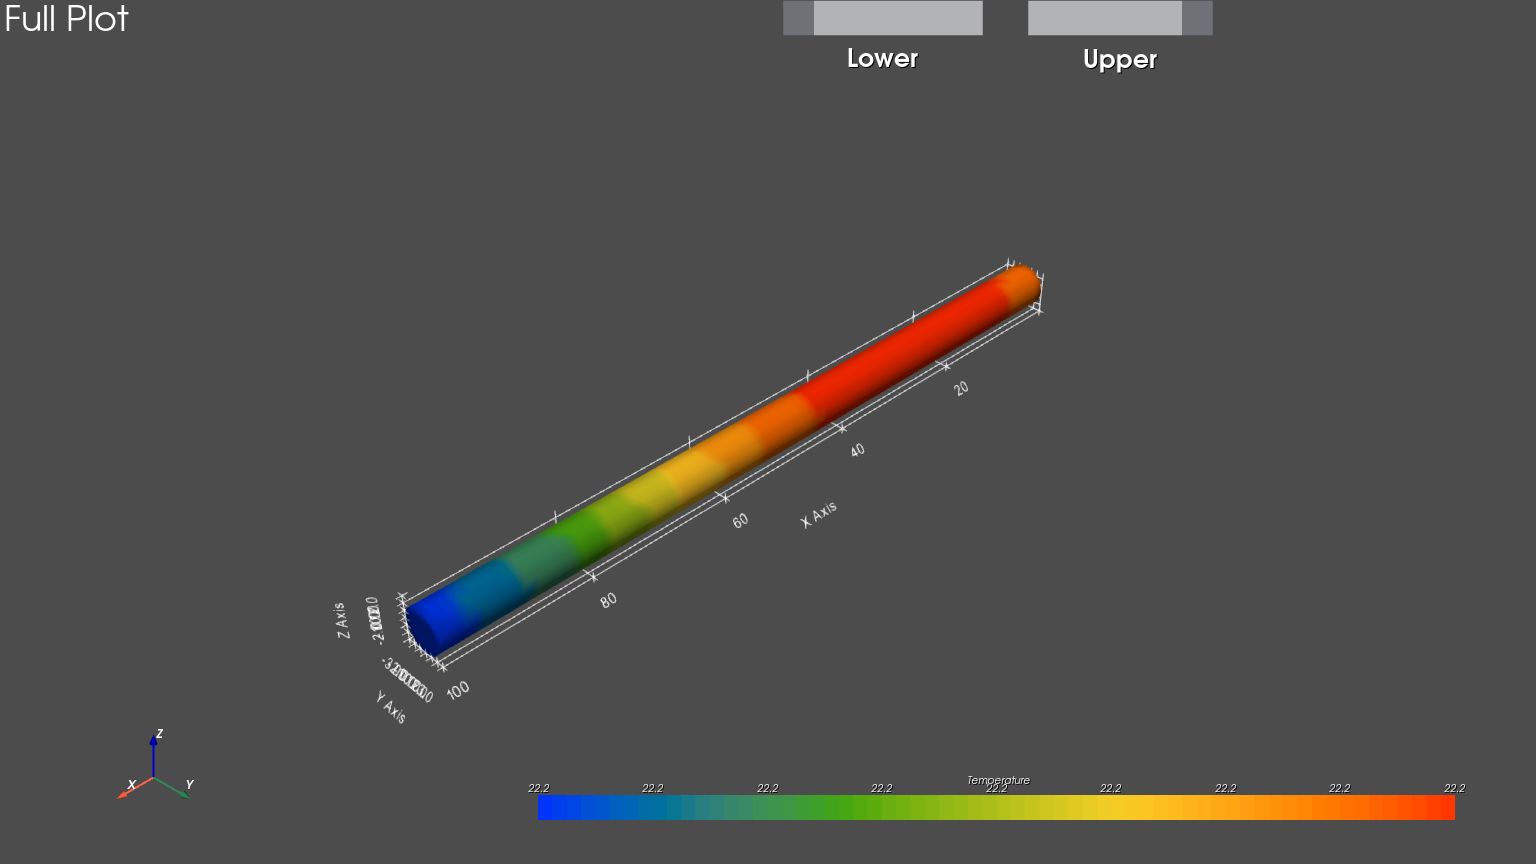

['C:\\Users\\mcapodif\\AppData\\Local\\Temp\\Example_1X813O\\Coaxial_Results_NG\\SurfTemperature_ZAQGMU.jpg']

In [23]:

ipkapp.post.plot_field_from_fieldplot(plot5.name, project_path=results_folder, meshplot=False, setup_name=setup_name, imageformat="jpg", view="iso")

In [24]:
aedtapp.save_project()

Info: Saving Test_Jupyter_NG Project


True

# Usage of Matplotlib and Numpy to generate graph outside pyaedt


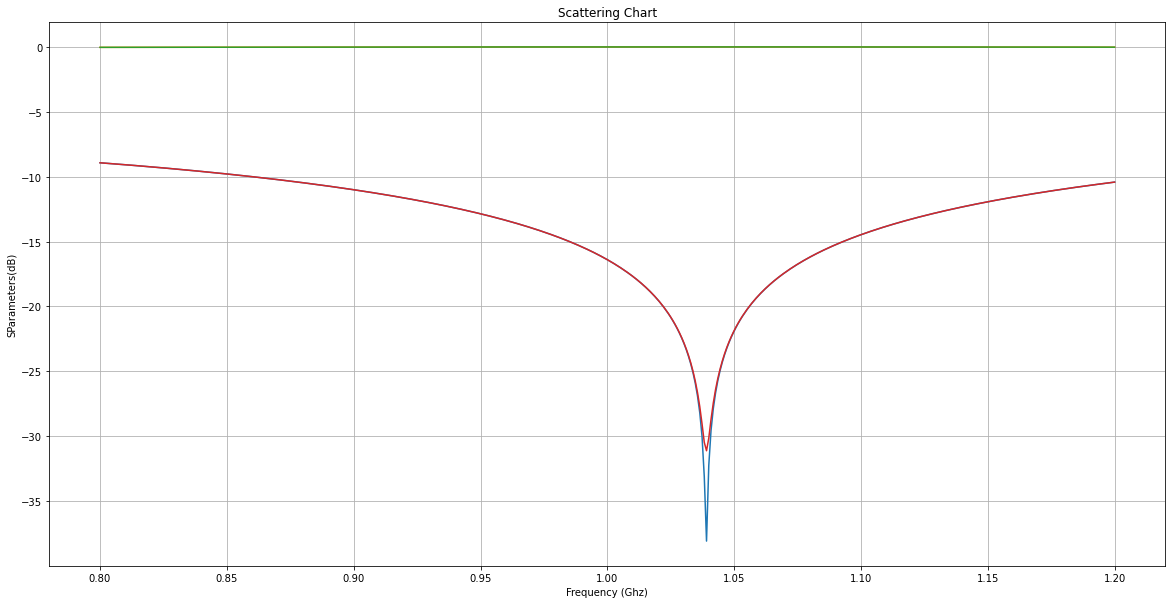

In [25]:
if advanced:
    trace_names = []
    for el in portnames:
        for el2 in portnames:
            trace_names.append('S(' + el + ',' + el2 + ')')
    cxt = ['Domain:=', 'Sweep']
    families = ['Freq:=', ['All']]
    my_data = aedtapp.post.get_report_data(expression=trace_names)
    freq_data = np.array(my_data.sweeps["Freq"])


    comp = []
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set(xlabel='Frequency (Ghz)', ylabel='SParameters(dB)', title='Scattering Chart')
    ax.grid()
    for el in trace_names:
        mag_data = np.array(my_data.data_db(el))
        ax.plot(freq_data, mag_data)
    plt.savefig(os.path.join(results_folder,project_name+".svg"))
    plt.savefig(os.path.join(results_folder,project_name+".jpg"))
    plt.show()


# Generating PDF Report

In [26]:

report = AnsysReport.CreatePdfReport()

report.Specs.ModelName = "Coaxial"
report.Specs.Revision = "Rev1"

report.Specs.AnsysVersion = "2021R1"
report.Specs.ProjectName = "MyCoaxial"
report.AddAnsysHeader()
report.AddFirstPage()
section2 = report.CreateNewSection()

report.AddChapter("Simulation Results")
testo = "The project name is " + report.Specs.ProjectName + "."
report.AddText(testo)
imagefiles = glob.glob(results_folder + "/*.jpg")
for img in imagefiles:
    report.AddImageWithCaption(img, img, 13)

report.AddChapter("Project Variables")

my_table = [["$dim", "$height"], ["5mm", "10mm"]]

mytable = create_table_for_csharp(my_table, True)
report.AddTableFromList("Project Variables", mytable, True, True)

report.AddTableOfContent()
filename=report.SavePDF(results_folder)
os.startfile(os.path.join(results_folder,filename))

# Close AEDT and Closed Project

In [27]:
aedtapp.close_project(aedtapp.project_name)
desktop.force_close_desktop()

Info: Closing the specified Test_Jupyter_NG AEDT Project
